<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/VAE_DOGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun  4 22:28:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!echo '3FDsALdx4sLyMedGxO5h:RsdZX1E2jRryINc6Vb5HGpL1FY84lNBXbTNSU8Ln' > ~/.passwd-s3fs

In [3]:
!cat ~/.passwd-s3fs

3FDsALdx4sLyMedGxO5h:RsdZX1E2jRryINc6Vb5HGpL1FY84lNBXbTNSU8Ln


In [0]:
!chmod 600 ~/.passwd-s3fs

In [0]:
!mkdir /s3

In [6]:
!apt install s3fs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  s3fs
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 200 kB of archives.
After this operation, 557 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 s3fs amd64 1.82-1 [200 kB]
Fetched 200 kB in 0s (2,311 kB/s)
Selecting previously unselected package s3fs.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../archives/s3fs_1.82-1_amd64.deb ...
Unpacking s3fs (1.82-1) ...
Setting up s3fs (1.82-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
!s3fs w251-final-project /s3 -o passwd_file=~/.passwd-s3fs,url=https://s3.us.cloud-object-storage.appdomain.cloud

In [8]:
!ls /s3

 caption_model.pth.tar
 CatImages
 dataset_coco.json.gz
 delivery.jpg
 DFDC
 haderfake.mp4
 image2.jpeg
 image3.jpeg
 image_captioning.ipynb
 kagglecatsanddogs_3367a.zip
 kat_ring0.mp4
 kat_ring1.mp4
 kat_ring2.mp4
 kat_ring3.mp4
 knowns
 model.pt.zip
 models.py
'MSR-LA - 3467.docx'
 new_faces.ipynb
 package.jpg
 package.mp4
 PetImages
 pman.jpg
 pretrained_weights
'readme[1].txt'
 Reuters_Deepfake.mp4
 testdir
 test_imgs
 uploads
 WORDMAP_coco_5_cap_per_img_5_min_word_freq.json.gz


In [0]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
BATCH_SIZE = 16         # number of data points in each batch
N_EPOCHS = 3            # times to run the model on complete data
HW_DIM = 64             # height/width 
INPUT_DIM = HW_DIM * HW_DIM   # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 100        # latent vector dimension
lr = 1e-3               # learning rate
NC = 3

In [0]:
transform = transforms.Compose([
        transforms.Resize(HW_DIM),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ])

In [0]:
dog_dataset = datasets.ImageFolder('/s3/PetImages', transform=transforms.Compose([
        transforms.Resize((HW_DIM,HW_DIM)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]))

In [14]:
dog_dataset

Dataset ImageFolder
    Number of datapoints: 12499
    Root location: /s3/PetImages
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485], std=[0.229])
           )

In [0]:
from torch.utils.data import DataLoader

In [0]:
dataloader = DataLoader(dog_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
print('Number of samples: ', len(dog_dataset))

Number of samples:  12499


In [0]:
class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r

In [0]:
from torchvision import models

In [49]:
for data in dataloader:
    x, y = data
    print(x.shape)
    break

torch.Size([16, 3, 64, 64])


In [65]:
x[0].max().item()

2.1632845401763916

In [67]:
np.abs(x[0].min().item())

1.9466564655303955

In [0]:
img = x[0]/x[0].max().item()

In [0]:
img = (img + 1)/2.0

In [74]:
img

tensor([[[0.7902, 0.8298, 0.3944,  ..., 0.8536, 0.8496, 0.7467],
         [0.6557, 0.8733, 0.5171,  ..., 0.8417, 0.7546, 0.6200],
         [0.3825, 0.7467, 0.7942,  ..., 0.7863, 0.6279, 0.5844],
         ...,
         [0.3588, 0.3232, 0.3073,  ..., 0.4696, 0.4736, 0.2955],
         [0.3707, 0.3509, 0.3350,  ..., 0.4775, 0.4855, 0.2915],
         [0.3390, 0.3430, 0.3271,  ..., 0.5013, 0.5013, 0.3153]],

        [[0.3905, 0.3509, 0.2915,  ..., 0.2519, 0.2480, 0.2242],
         [0.4775, 0.3707, 0.3113,  ..., 0.2440, 0.2242, 0.1767],
         [0.2440, 0.2638, 0.3825,  ..., 0.2321, 0.1886, 0.1807],
         ...,
         [0.4261, 0.3984, 0.3905,  ..., 0.3192, 0.2994, 0.1688],
         [0.4340, 0.4142, 0.4023,  ..., 0.3430, 0.3390, 0.1728],
         [0.3984, 0.4023, 0.3984,  ..., 0.3667, 0.3588, 0.1886]],

        [[0.4063, 0.4221, 0.3667,  ..., 0.3271, 0.3311, 0.3073],
         [0.4815, 0.4498, 0.3746,  ..., 0.3271, 0.3113, 0.2598],
         [0.2559, 0.3350, 0.4419,  ..., 0.3232, 0.2757, 0.

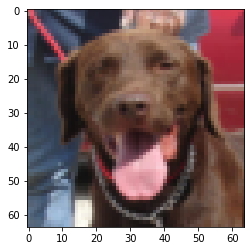

In [75]:
plt.imshow(img.permute(1,2,0).numpy())

In [76]:
y.shape

torch.Size([16])

In [0]:
i = torch.randn(16, 100).view(-1,100,1,1)

In [0]:
def hout(hin,kernel_size,stride=1,padding=0,dilation=1,output_padding=0):
  return ((hin-1)*stride - 2*padding + dilation*(kernel_size-1) + output_padding+1)

In [117]:
hout(1,4,1,0)

4

In [121]:
hout(4,4,2,1)

8

In [122]:
hout(8,4,2,1)

16

In [123]:
hout(16,4,2,1)

32

In [0]:
f = nn.ConvTranspose2d(LATENT_DIM, HW_DIM * 8, 4, 1, 0, bias=False) # HW_DIM * 8 = 512

In [0]:
o = f(i)

In [109]:
o.size()

torch.Size([16, 512, 4, 4])

In [0]:
f2 = nn.ConvTranspose2d(HW_DIM * 8, HW_DIM * 4, 3, 2, 1, bias=False)

In [0]:
o = f2(o)

In [112]:
o.size()

torch.Size([16, 256, 7, 7])

In [0]:
f3 = nn.ConvTranspose2d(HW_DIM * 4, HW_DIM * 2, 4, 2, 1, bias=False)

In [0]:
o = f3(o)

In [115]:
o.size()

torch.Size([16, 128, 14, 14])

In [0]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.resnet = models.mobilenet_v2(pretrained=True)
        self.linear = torch.nn.Linear(1000, HIDDEN_DIM)

    def forward(self, x):
        x = self.resnet(x)
        return F.relu(self.linear(x))

In [0]:
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(LATENT_DIM, HW_DIM * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(HW_DIM * 8),
            nn.ReLU(True),
            # state size. (HW_DIM*8) x 4 x 4
            nn.ConvTranspose2d(HW_DIM * 8, HW_DIM * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(HW_DIM * 4),
            nn.ReLU(True),
            # state size. (HW_DIM*4) x 8 x 8
            nn.ConvTranspose2d(HW_DIM * 4, HW_DIM * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(HW_DIM * 2),
            nn.ReLU(True),
            # state size. (HW_DIM*2) x 16 x 16
            nn.ConvTranspose2d(HW_DIM * 2, HW_DIM, 4, 2, 1, bias=False),
            nn.BatchNorm2d(HW_DIM),
            nn.ReLU(True),
            # state size. (HW_DIM) x 32 x 32
            nn.ConvTranspose2d(HW_DIM, NC, 4, 2, 1, bias=False),
            # state size. (NC) x 64 x 64
            # nn.Tanh()
            nn.Sigmoid()
        )

    def forward(self, x):
        deconv_input = x.view(-1,LATENT_DIM,1,1)
        return self.decoder(deconv_input)

In [0]:
class VAE(torch.nn.Module):

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(HIDDEN_DIM, LATENT_DIM)
        self._enc_log_sigma = torch.nn.Linear(HIDDEN_DIM, LATENT_DIM)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = F.relu(self._enc_mu(h_enc))
        log_sigma = F.relu(self._enc_log_sigma(h_enc))
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False).to(device)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)

In [0]:
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

In [0]:
encoder = Encoder(INPUT_DIM, HIDDEN_DIM)
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)
vae = VAE(encoder, decoder)

In [0]:
vae = vae.to(device)

In [135]:
vae

VAE(
  (encoder): Encoder(
    (resnet): MobileNetV2(
      (features): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Co

In [0]:
criterion = nn.MSELoss()

In [0]:
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

In [0]:
from tqdm import tqdm

In [0]:
EPOCHS=5

In [0]:
#inp = torch.randn(16, 100)

In [129]:
#inp.size()

torch.Size([16, 100])

In [0]:
#o = vae.decoder(inp.to(device))

In [137]:
#o.shape

torch.Size([16, 3, 64, 64])

In [0]:
#o = vae(x.to(device))

In [139]:
#o.size()

torch.Size([16, 3, 64, 64])

In [140]:
#o[0]

tensor([[[0.5266, 0.5220, 0.6008,  ..., 0.5171, 0.5086, 0.4637],
         [0.5573, 0.6803, 0.5043,  ..., 0.6863, 0.5252, 0.5737],
         [0.5496, 0.6474, 0.4794,  ..., 0.4919, 0.5123, 0.5175],
         ...,
         [0.5331, 0.6642, 0.5593,  ..., 0.6039, 0.5379, 0.5945],
         [0.4964, 0.3791, 0.4420,  ..., 0.5178, 0.6905, 0.4827],
         [0.5204, 0.5334, 0.4680,  ..., 0.4375, 0.5385, 0.5267]],

        [[0.4876, 0.4975, 0.4309,  ..., 0.5202, 0.4451, 0.4961],
         [0.4424, 0.6119, 0.4166,  ..., 0.5668, 0.4640, 0.5275],
         [0.4659, 0.3007, 0.4909,  ..., 0.3930, 0.5285, 0.5037],
         ...,
         [0.4232, 0.4815, 0.2611,  ..., 0.4371, 0.3556, 0.4007],
         [0.5517, 0.4705, 0.4664,  ..., 0.6621, 0.5661, 0.3691],
         [0.5058, 0.4640, 0.4795,  ..., 0.5023, 0.4985, 0.4792]],

        [[0.4649, 0.6225, 0.3246,  ..., 0.5027, 0.3651, 0.4967],
         [0.4314, 0.4224, 0.4342,  ..., 0.4704, 0.5765, 0.4989],
         [0.4641, 0.4870, 0.3120,  ..., 0.3975, 0.2263, 0.

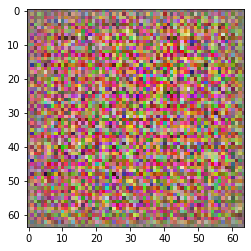

In [144]:
#plt.imshow(o[0].cpu().permute(1,2,0).detach().numpy())

In [1]:
l = []
best_loss = None
for epoch in tqdm(range(EPOCHS)):
    e_loss = 0
    for data in dataloader:
        X, y = data
        #inputs  = X.view(-1, INPUT_DIM)
        #inputs = Variable(inputs.resize_(batch_size, input_dim))
        optimizer.zero_grad()
        dec = vae(X.to(device))
        ll = latent_loss(vae.z_mean, vae.z_sigma)
        loss = criterion(dec.view(-1, 3, 64, 64), X.to(device)) + ll
        loss.backward()
        optimizer.step()
        e_loss += loss.item()
    print("Epoch {}: loss={}".format((epoch+1), e_loss))
    l.append(e_loss)
plt.plot(l)

NameError: ignored

In [0]:
z = torch.randn(1, LATENT_DIM)

In [40]:
z

tensor([[ 1.2485,  1.2613,  0.1082, -1.0682, -0.8273, -0.5560,  0.7324, -0.0368,
         -0.6798,  0.9109, -2.1242, -0.4738,  0.9141,  0.8428,  1.8409, -1.1791,
         -0.7983,  2.5173,  0.2267, -0.1835,  0.9431, -0.4914,  0.7744,  1.2204,
         -0.1453, -0.2739, -0.0704,  0.9547,  0.6944,  0.1075, -0.7883, -1.0663,
         -1.4159, -1.6122,  0.6292,  1.1373,  1.2469, -1.6067,  0.5278,  0.3275,
         -1.7010, -1.6406,  0.2626,  0.3661,  0.4169, -0.6242,  0.4959,  0.6491,
         -0.0964,  1.2023,  0.8351,  0.4376, -1.2060,  2.1132, -0.5800,  0.3064,
         -0.0789, -0.6830,  0.0821,  1.1480, -0.4766, -0.6619,  0.0829,  0.3300,
         -0.9195,  1.7008,  0.6960,  0.4471,  0.8182,  0.5834,  0.2224,  2.4245,
          0.9882, -0.3089, -0.9415, -1.5697,  3.4972, -0.3444,  1.5366, -0.5316,
         -0.5306,  0.1791,  1.2953,  0.3307, -0.7265, -0.8152,  0.8672, -0.3107,
         -0.4713,  0.8954,  0.0528, -1.9482,  0.7782,  0.0495, -1.2675, -0.8366,
          0.6167,  0.5343, -

In [41]:
z.shape

torch.Size([1, 100])

In [0]:
out = vae.decoder(z.to(device))

In [43]:
out.shape

torch.Size([1, 12288])

In [0]:
img = out.cpu().view(3,64,64).permute(1,2,0).detach().numpy()

In [67]:
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.04878965, 0

In [0]:
img *= 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


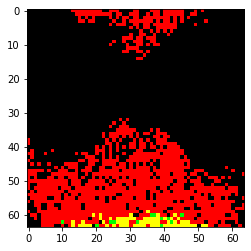

In [71]:
plt.imshow(img)